## Rich feature hierarchies for accurate object detection and semantic segmentation(R-CNN)

### Abstract
이 논문에서는 mAP를 53.3%까지 달성한 simple scalable 알고리즘을 제안함
2가지 핵심적인 통찰이 있는데,
1. 고용량 CNN을 object localize 및 segment를 하기위해 bottom-up region proposal에 적용했다.
2. label 이 있는 train set이 부족할 경우, supervised pre-traning 을 하고 domain-specific fine-tuning을 하여 성능을 boost 함  

R-CNN은 Overfeat 대비 200-class ILSVRC2013 detection set에서 뛰어났음

### Introduction
지난 10여년 전에는 다양한 visual 인식이 SIFT와 HOG에 기초되었었다.  
< *HOG는 일종의 템플릿 매칭이기 때문에 물체가 회전된 경우나 형태변화가 심한 경우에는 검출이 힘들지만 SIFT는 모델의 특징점과 입력 영상의 특징점에 대해 특징점 단위로 매칭이 이루어지기 때문에 물체의 형태변화, 크기변화, 회전 등에 무관하게 매칭이 이루어질 수 있다. 이러한 특성에 비추어 보았을 때, HOG는 물체의 형태변화가 심하지 않고 내부 패턴이 단순하며 물체의 윤곽선으로 물체를 식별할 수 있을 경우에 적합하고 SIFT는 액자 그림과 같이 내부 패턴이 복잡하여 특징점이 풍부한 경우에 적합한 방법이다.>

SIFT, HOG를 이용한 시각 인식 분야의 발전이 있었지만 PASCAL VOC 에서는 정체되었음 SIFT, HOG는 블럭단위의 방향 히스토그램으로 <span class="mark">영장류 시각경로의 V1영역과 유사함</span>. 인식은 다단계의 하방성으로 일어남을 알고 있기에 시각 인식을 위해서 <span class="mark">다단계로 feature를 계산</span>하는 방법을 취함.

Fukushima의 “neocognitron” 이란 것도 있음
CNN은 1990년대에 많이 쓰다가 SVM 등장으로 쇠퇴했다가 2012년에 Krizhevsky가 ImageNet 대회를 통해 다시 관심을 불러일으켰는데 1백2십만개의 label 된 이미지에 대해 LeCun CNN을 변형한 CNN (ReLU와 dropout 적용)으로 train 한 결과로 성공함

당시 어느 정도로 <span class="mark">ImageNet의 CNN classification</span> 결과가 <span class="mark">PASCAL VOC의 object detection</span> 결과에 일반화될 수 있을지 논쟁이 있었음. 이에 우리는 이 둘 사이의 차이를 이으면서 답변을 하고자하는데 이 논문이 최초로 CNN을 PASCAL VOC의 image detection에 적용하여 높은 결과를 낼 수 있음을 보임
이 결과를 위해 두가지 문제에 집중함 : deep network으로 object를 localize 하는것과 대용량의 모델을 적은 양의 label된 detection data로 train 하는 것

이미지내의 object를 localize 하는 첫번째 방법은 regression 문제로 하는것인데 실제로 mAP가 안좋았음

다른 방법은 sliding-window detector를 만드는 것인데 CNN이 한 20년 동안 얼굴이나 보행자 등 제한적인 object 카테고리로 여기에 사용되었음. 또 고해상도를 위해 보통 conv 와 pooling 2개의 layer만 사용했음.

우리도 sliding-window를 사용을 검토했었는데, 우리 network은 5개의 conv layer와 큰 receptive field (195x195)와 stride (32x32) 를 적용하였기에 sliding-window로 정확한 localization 을 하기는 어려웠음.

대신 우리는 이 문제를 region을 사용한 인식 방법으로 해결했는데 이는 object detection과 semantic segmentation 문제에 다 성공적임. 우리 방법은 입력 이미지에 대해 2000개의 카테고리 무시한 region proposal을 하고 각 proposal에 대해 CNN을 사용하여 고정길이의 feature 벡터를 추출한 다음 각 region을 카테고리 특정된 선형 SVM으로 classify 함. 근접 이미지 warping 이라는 기법을 사용하여 각 region proposal로 부터 region의 형태에 상관없이 고정 크기의 CNN 입력을 계산함.

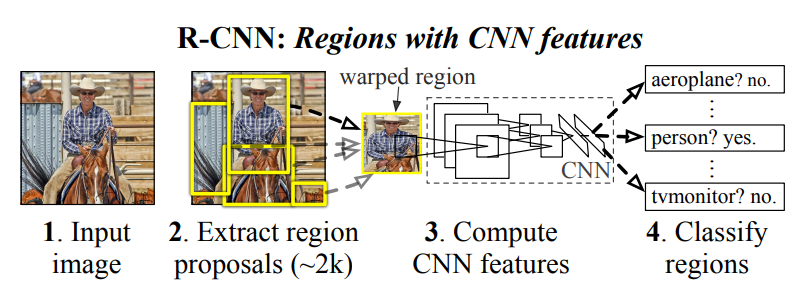
수정된 논문에서 R-CNN과 최근 제안된 OverFeat와 비교함.

detection 에서의 두번째 문제는 label data가 부족한 것인데 종래에는 unsupervised pre-traning하고 supervised fine-tuning하는 것이도 두번째 방법은 큰 dataset에 대해 (ILSVRC) supervised pre-training 하고 작은 dataset (PASCAL)에 대해 domain-specific fine-tuning하는 것

본 시스템은 매우 효율적인데 유일한 class-specific 계산은 matrix-vector 곱과 greedy non-maximum suppression 임. 이런 계산상의 특성은 모든 카테고리에서 feature를 공유한다는 것과 이전의 region feature 보다 수백배 작은 크기의 차원이라는 점에 기인함.

R-CNN이 region 에 동작하므로 semantic segmentation 에도 자연스럽게 확장되는데 조금만 수정하면 PASCAL VOC의 경쟁력있는 결과를 만들어냄

### 2. Object detection with R-CNN

본 시스템은 3개의 모듈로 구성됨. 첫째 카테고리에 무관한 region proposal 두번째는 큰 CNN, 세번째는 class-specific linear SVM

#### 2.1. Module design

Region Proposals :objectness, selective search, category-independent object proposals, constrained

parametric min-cuts (CPMC), multi-scale combinatorial grouping, mitotic cells. R-CNN에서는 selective

search 사용

Feature extraction : Caffe를 사용하여 각 region proposal에서 4096차원의 feature vector를 추출함. feature는 5개의 conv와 2개의 fc layer를 통해 평균을 뺀 227x227 RGB 이미지를 forward 시키면서 계산함. region proposal은 227x227 로 변환함. 변환은 가장 간단한 것으로 했는데 사이즈나 비율과 상관없이 모든 픽셀을 tight bbox로 warp 함. warp 전에 tight bbox를 부풀려 warp 된 사이즈에서 원래 box 주위의 p 픽셀만큼의 context를 둔다. (p=16 사용)

#### 2.2. Test-time detection

테스트시에 테스트 이미지에 대해 selective search를 수행하여 2000개의 region proposal을 추출하고 각 proposal을 warp하고 CNN에 넣어 forward시켜 feature를 뽑음. 이후 각 class 별로 그 feature 벡터에 대해 SVM으로 스코어를 매김. 스코어 매겨진 모든 region에 대해 greedy non-maximum suppression 수행하여 어떤 영역이 학습된 임계값보다 더 높은 점수를 받아 선택된 영역과 겹치는 경우 (IoU) 그 영역을 거부함.

Run-time analysis : 2가지 특성으로 detection 이 효율적임. 첫째 모든 CNN parameter는 모든 카테고리에서 공유됨. 둘째 CNN에서 계산된 모든 feature 벡터는 다른 공통 접근법에  (bag-of-visula-word 의 spatial pyramids 등) 비하면 저차원임. 예로 UVA detection system에 사용되는 feature는  100배나 큼 (360k vs 4k domensional).

공유의 결과 region proposal과 feature를 계산하는 시간은 (13s on GPU, 53 on CPU) 모든 class에 대해 분할됨. 유일하게 class 특정한 계산은 feature와 SVM weight 의 dot product 및 non-maximum suppression 임. 실제로는 모든 dot product은 하나의 matrix 간 곱으로 쪼개짐, feature matrix는 보통 2000x4096 이고 SVM weight matrix는 4096xN 임.

본 분석은 R-CNN이 hashing 같은 근사기법에 의존하지 않고도 수천개의 object로 확장할 수 있음을 보여줌. 100k개의 class가 있어도 matrix 곱은 multi-core CPU로 10초면됨. 이 효율성은 단순히 region proposal과 공유 feature 의 결과 뿐만 아님. UVA system은 고차원의 feature 때문에 수백배나 느리고 134GB의 memory가 필요한 반면 본 시스템은 1.5GB 의 저차원임.

R-CNN과 최근의 DPM 과 hashing을 이용한 최근의 scalable detection 과 비교하는 것도 흥미로운데 본 결과가 훨씬 좋음

 

#### 2.3. Training

Supervised pre-training : 우리는 CNN을 ILSVRC2012 dataset에서 image label 만 이용하여 pre-train 함 (bbox label은 없음). pre-train은 Caffe CNN library를 이용함. 본 CNN은 Krizhevsky의 결과와 비등함.

Domain-specific fine-tuning : 본 CNN을 새로운 task에 (detection) 과 새로운 domain (warped windows) 에 적용하기 위해 CNN parameter를 warped region proposal을 사용하여 SGD traing을 계속함. 그 CNN을 ImageNet 특정의 1000개의 classification layer에 임의로 초기화된 N+1개의 classification layer 로 (+1은 background임) 대체하는 것에 말고는 CNN 구조는 그대로임. VOC에는 N=20 이고 ILSVRC2013에서 N=200임. region proposal는 해당 box class의 positive 로는 gt와 0.5 IoU 이상인 것과 나머지는 negative 인 proposal 만 사용함. SGD는 learning rate 0.001 (pre-train 초기 rate의 1/10) 로 하여 fine-tuning이 초기화를 무력화시키지 않고 진행하게 함. 각 SGD iteration 시, 균일하게 32개의 모든 class의 positive window와 96개의 background window를 뽑아 128크기의 batch를 구성함. background에 비해 positive window는 드물기에 수치를 차별함.

Object category classifiers : car를 구별하는 이진 classifier를 train하는 것은 생각해보면, car를 꽉차게 둘러싸는 region이 positive 임은 명확함. car와 상관없는 background 영역도 negative임이 명확함. car에 부분적으로 겹친 region은 IoU 임계값으로 처리함. 임계값 0.3이 0~0.5중 val set에 대한 grid search 로 선택됨. 이 값은 신중해야 하는데 0.5로 하면 mAP가 5 감소, 0으로 하면 4 감소. positive exampe들은 단순히 각 class의 gt box로 정의됨. 일단 feature 가 추출되고 train label이 적용되면 class당 하나의 linear SVM을 최적화함. train data는 메모리에 넣기에 너무 크기에 standard hard negative mining을 적용함. hnm 은 빨리 수렴하고 실제로 mAP가 모든 이미지에서 single pass후 증가를 멈춤.

부록 B에 왜 postive와 negative example이 SVM train 대비 fine-tuning시 차별적으로 정의되는지 설명함. 또 fine-tuned CNN의 최종 softmax layer의 출력을 단순히 사용하는 것 대비 training detection SVM에 포함된 trade-off를 논함.

 

#### 2.4. Results on PASCAL VOC 2010-12

PASCAL VOC 최고수행과정을 따라서 VOC 2007 dataset에 대해 모든 설계결정과 hyperparameter를 validate함. VOC 2010-12 최종 dataset에 대해서 CNN을 train하고 optimize함 테스트 결과는 두개의 알고리즘 변수에 (bbox regression 있는 것과 없는것) 대해서 서버에 제출함.

우리 방법을 4개의 기본방법과 비교함, 특히 DPM을 semantic segmentation system과 결합하고 추가의 detector간 context 와 이미지 classifier rescoring 으로 하는 SegDPM을 포함함. 가장 연관된 것은 UVA system인데 같은 region proposal을 사용함. region을 classify 하기 위해 UVA는 4단 spatial pyramid를 만들어 densely sampled SIFT, Extended OpponentSIFT, RGBSIFT descriptors로 채우고 각 벡터는 4000 워드로 덩어리짐. classification은 histogram intersection kernel SVM으로 수행됨. 그것과 비교해서 우리는 더 나은 mAP를 달성하고 더 빠름.

 

#### 2.5. Results on ILSVRC2013 detection

R-CNN을 200-class ILSVRC2013 detection dataset에 PASCAL VOC에서와 같은 hyperparameter를 사용했고 똑같은 방식으로 제출했음.


### 3. Visualization, ablation, and modes of error

#### 3.1. Visualizing learned features

첫 layer 필터는 시각화되고 쉽게 이해는데 방향성 에지와 반대 색상을 잡아냄. 이후 layer는 어려운데  Zeiler와 Fergus는 시각적이고 흥미로운 <span class="mark">deconv</span> 방법을 제시함. 우리도 네트웍이 무엇을 학습했는지 직접 보여주는 단순하고 보완적인 non-parametric 방법을 제안함.

그 방법은 네트웍에서 특별한 유닛 (feature)을 뽑아내어 그것이 자체로 object detector인듯 사용하는 것임. 즉 우리는 1000만개 정도의 뽑힌 거대한 region proposal 세트에서 유닛의 activation을 계산하고 그 proposal을 가장 큰 activation 부터 가장 작은 것까지 정렬하고, nms를 수행하고, 높은 스코어의 region을 보여줌. 이 방법은 선택된 유닛이 어떤 입력이 촉발시켰는지 자체로 보여주게 됨. 우리는 다른 시각 모드를 보기 위해 평균을 취하는 것을 피하고 유닛으로 계산되는 불변성에 대한 통찰을 얻음.

우리는 conv 의 최종단인 pool5 layer에서 시각화하는데 그 feature는 6x6x256=9216 차원임. 경계를 무시하면 pool5의 유닛의 receptive field는 195x195 임 (입력은 227x227). 따라서 pool5 유닛은 에지말고는 거의 globa한 뷰임.

그림4의 각 행은 pool5 유닛에 대해 VOC2007 train값을 fine-tune한 CNN에서 가장 높은 16개의 activation을 보여줌. 256개의 기능적으로 특이한 유닛 중 6개가 시각화됨. 이것은 네트웍이 무엇을 학습했는지 보여주기 위해 선택됨. 둘째 줄에 개 얼굴과 점의 배열에 촉발한 유닛을 보고 3열은 red blob detector임. 사람 얼굴이나 글자나 삼각 구조 등 더 추상적 패턴 detector도 있음. 그 네트웍은 작은 수의 class-tuned feature와 형태, 질감, 색상, 물성 등을 조합한 표현을 학습하는 듯함. 이후 fc6 layer는 이런 풍성한 feature의 합쳐진 거대한 셋을 모델하는 능력을 가짐.

 

#### 3.2. Ablation studies

Performance layer-by-layer, without fine-tuning :

어떤 layer가 detection 성능에 가장 중요한지 이해하려고 VOC 2007 dataset 결과를 CNN의 마지막 3 layer에 대해 분석함. pool5는 위에서 얘기했고 마지막 2 layer는 아래에 정리됨. fc6의 feature를 계산하려고 4096x9216 의 weight matrix에 9216차원으로 변형된 pool5의 feature map을 곱하고 bias를 더함. 이 벡터는 다시 항목별로 ReLU 적용함. fc7이 최종 layer인데 fc6의 feature에 4096x4096 weight matrix를 곱하고 bias를 더하고 ReLU 적용함.

PASCAL에서 fine-tuning 없는 결과, 즉 모든 CNN parameter는 ILSVRC 2012로 pre-train 된 결과를 보면, layer별 분석에서 fc7의 feature가 fc6의 feature 보다 대개 나쁜데 이는 29% 1680만개의 CNN parameter를 제거해도 AP 저하는 없음을 보임. 더 놀라운 것은 fc6와 fc7 을 제거했을때 pool5 feature가 CNN parameter 6% 만 사용하여 계산했음에도 꽤 좋은 결과가 나옴. CNN 표현력의 많은 부분이 fc 보다는 conv layer 로부터 나옴. 이 발견은 HOG 등에서 임의의 크기의 이미지를 단지 conv layer만으로 dense feature map을 계산함에 있어 유용함.

Performance layer-by-layer, with fine-tuning :

fine-tune 된 결과를 보면 개선이 놀라운데 fc6, fc7에서의 개선이 pool5 보다 큼. 이는 ImageNet으로 학습된 pool5 feature가 일반적이고 이후의 개선은 domain-specific non-linear classifier에 의한 것임을 알려줌.

Comparison to recent feature learning methods :

 

#### 3.3. Network architectures

본 논문의 대부분의 결과는 Krizhevsky의 네트웍 구조사용. 구조의 선택은 R-CNN 성능에 영향이 큼. 테이블3에 최근 제안된 16-layer 구조의 결과를 보여줌. 이 네트웍은 conv 13 layer인데 3x3 커널을 사용했고 5개 max pooling을 배치했고 상위에 3개의 fc layer가 있음.  이 네트웍은 O-Net, T-Net 이라 칭함.

O-Net을 사용하려면 pre-trained 네트웍 모델을 다운받으면됨. 받은 후 T-Net에 사용한 똑같은 포로토콜을 사용하여 fine-tune 함. 차이점은 GPU 메모리에 맞추기 위해 작은 미니배치를 사용한 것임. O-Net이 T-Net보다 훨씬 나은데 계산시간이 fowrard 경우 7배나 더 걸리는 단점도 있음.

#### 3.4. Detection error analysis

본 방법의 error mode를 밝히고 fine-tune의 효과, DPM과의 비교를 위해 Hoiem 등의 detection 분석 툴을 적용함. 상세한 것은 본 논문의 범위를 넘어섬. 그림5와 6을 참조할 것.

#### 3.5. Boundingbox regression

에러 분석에 근거하여 localization 에러를 줄이기 위한 단순한 방법을 구현함. DPM에서 채용한 bbox regression에 자극 받아서 우리는 selective search region proposal에서 pool5 feature를 받은 새로운 detection window를 예측하기 위해 linear regression model을 학습함. 자세한 것은 부록과 그림5에 어떻게 많은 잘못된 detection을 고치는지 보여줌.

#### 3.6. Qualitative results

정성적 결과에 대해 그림8,9,10,11을 볼것.

### 4. The ILSVRC2013 detection dataset

#### 4.1. Dataset overview

#### 4.2. Region proposals

#### 4.3. Training data

#### 4.4. Validation and evaluation

#### 4.5. Ablation study

#### 4.6. Relationship to OverFeat

 

### 5. Semantic segmentation

region classification은 semantic segmentation의 표준 기술로 R-CNN으로 쉽게 PASCAL VOC segmentation 대회에 적용 가능함. O2P라 불리는 현재 가장 앞선 segmentation system 과 직접 비교를 가능하게 하기 위해 그들의 오픈소스 프레임웍을 이용함.O2P는 이미지당 150개의 region proposal을 생성하기 위해 CPMC를 사용하고 각 class에 대해 SVR (support vector regressor)를 이용해 각 region의 질을 예측함.그들 방법의 고성능은 CPMC region의 질과 여러 feature type의 강력한 2차 pooling에 기인함.우리도 Farabet 등이 CNN을 여러 스케일의 픽셀별 classifier로 고밀도 장면 label dataset에 좋은 결과를 냈음을 주목함.

우리는 PASCAL seg train set을 확장하여 Hariharan 등이 유용하게 만든 추가 annotation을 포함시킴. 설계와 hyperparameter는 VOC 2011 val set에서 교차검증되고 최종 테스트 결과는 한번만 평가됨.

CNN features for segmentation :

CPMC region에 대한 feature를 계산함에 3가지 전략을 취하는데 모두 227x227 로 warp 하며 시작함. 첫번째 전략은 (full)  region의 형태를 무시하고 기존 한 것과 똑같이 warped 윈도우에서 CNN feature를 직접 계산함. 그런데 이 feature는 region이 직사각형이 아닌 것은 무시하기에 별로 겹치지 않는 두개의 region 이라도 비숫한 bbox를 가질 수 있음. 두번째 전략은 (fg) region의 foreground mask에 대해서만 CNN feature를 계산함. 우리는 background를 그 평균 입력으로 대체하여 평균을 빼면 background가 0이 되게함. 세번째 전략은 (full+fg) 단순히 full과 fg feature를 합침. 실험으로 상보성을 확인함.

Results on VOC 2011 :

테이블3이 O2P와 비교한 결과인데 모든 방법에서 fc6가 fc7을 능가함. fg 전략은 full 을 조금 능가하는데 mask된 형태가 더 강한 신호를 제공하는 것이 직관과 일치함. 그러나 full+fg 가 O2P를 능가하며 제일 좋은 결과를 내는데 full feature가 제공하는 context가 fg feature가 주어지더라도 더 정보성이 있음. 주목할 것은 20 SVR을 full+fg feature 에 학습하는 것이 1 코어로도 1시간이면 충분 (O2P는 10시간)

 

### 6. Conclusion

Appendix

A. Object proposal transformations

B. Positive vs. negative examples and softmax

C. Bounding-box regression

D. Additional feature visualizations

E. Per-category segmentation results

F. Analysis of cross-dataset redundancy

G. Document changelog

### 요약
Introduction

 R-CNN은 UC Berkeley 연구팀에서 개발한 Object Detection 모델이다. 지금 와서는 Approach가 다소 Naive하기도 하고 Faster R-CNN, YOLO 등의 걸출한 모델들이 존재하지만, 당시 기준으로는 알고리즘의 비효율을 떠나 높은 정확도를 기록하며 ILSVRC2013 대회에서 1위를 기록했기에 Detection 분야를 공부하기 위해서는 한번쯤 읽어봐야 할 논문이며 이후 등장한 Fast R-CNN, Faster R-CNN, Mask R-CNN 등의 이해를 위해서도 내용을 숙지해야 할 필요가 있다.

​

​

Algorithms


 

 R-CNN은 이미지 하나에서 수많은 Proposal들을 뽑아내고 모든 Proposal들을 CNN 모델에 통과시킨 뒤  SVM을 거쳐 Classification을 하고 이후 Regressor를 통해 Bounding Box Prediction을 수행하는 단계로 진행된다.

​

1. Region Proposals

 Region Proposal은 아무것도 없는 상태에서 이미지만을 보고 Object가 존재할 가능성이 있는 모든 RoI를 뽑아내는 단계이다. 이들은 Selective Search 알고리즘을 사용해 이미지 하나에 대해 약 2000장의 RoI를 뽑아냈다.

​

2. Feature Extraction

 이후 각각의 Proposal을 227x227의 Fixed-size로 Resize시킨 뒤 (논문에서는 Warp라고 표현) 일일히 CNN을 통과시켜 Feature Extraction을 수행했다. 모델은 ILSVRC2012 Dataset을 Pre-training시킨 AlexNet을 사용했으며 최종 Feature 수는 4096개이다. 

 이 단계는 개선의 여지가 많다. 먼저 Warping은 본래 Proposal 고유의 Ratio를 무시하게 되며 데이터의 왜곡이 일어날 가능성이 존재한다. 다음으로 이미지 하나당 몇 천 번의 Feed-forwarding이 이루어지므로 엄청나게 많은 시간이 소요된다. 이 문제점들은 이후 등장한 R-CNN 계열 논문에서 점차 해소된다.

​

3. SVM

 이제 분류를 위해 SVM을 학습시킨다. 이미지 하나에서 나온 Proposal들의 총 Feature Map Dimension은 약 2000x4096이며, 이를 4096 x (N+1) (Number of Classes + Background)의 Weight를 가진 SVM에 넣어 Classification을 수행한다. 행렬곱 연산에 의해 최종 Dimension은 약 2000 x (N+1)이 되며 이는 2000개 가량의 Proposal들이 각각 어떤 클래스에 속하는지를 알려준다. 여기서 만일 Proposal이 Grountruth Box와 절반 이상 겹치면 Object가 존재한다고 간주해 해당 클래스로 분류하고, 그렇지 않으면 Background로 분류한다.

​

4. Regressor

 이제 정밀한 Localization을 위해 Bounding Box를 학습시키는 마지막 단계가 남았다. Bounding Box는 (x, y, w, h)로 구성되며 Box의 중심좌표, 높이 및 너비를 의미한다. Bounding Box를 따로 학습시키는 이유는, 위의 Classification 단계에서 절반 이상만 겹치면 Object로 판단하는 관대한 기준을 적용했기에 분류는 비교적 정확할지 몰라도 위치는 많이 벗어날 수 있기 때문이다. 따라서 Rough한 기존의 Bounding Box를 Groundtruth의 그것에 일치시키는 방향으로 Regressor를 학습시켜 보정을 해줘야 한다.

 

​

Results


 VOC 2010 Testset에 대한 mAP 결과를 Selective Search를 사용한 다른 모델들과 비교한 표이다.
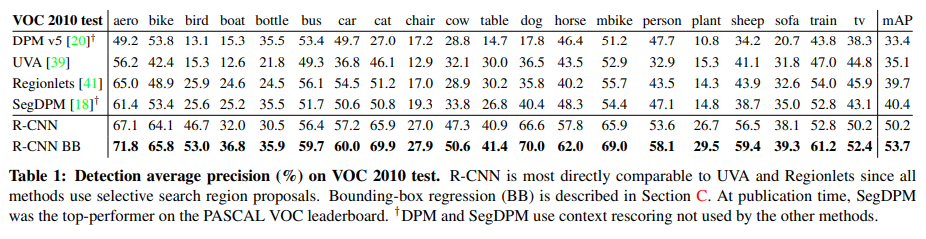
​

​

Limitations

 위에서도 언급했듯이 R-CNN은 몇 가지 한계가 존재한다.

​

1. Multistage Algorithm

 CNN, SVM, Regressor를 각각 따로 학습시켜야 하는 번거로움이 있다.

​

2. High Training Cost

 이미지 하나당 2000개 가량의 Proposal이 생성되기 때문에 메모리에 부담이 될 뿐만 아니라 전부 CNN을 통과시켜야 하므로 시간이 굉장히 많이 걸린다. Training시 소모된 시간은 2.5 GPU-Day였다.

​

3. Slow Testing Speed

 학습을 마친 뒤, 테스트시에도 이미지 하나 당 47초가 소모되기에 실시간 서비스 등에 적용할 수 없다는 한계가 있다.
[출처] R-CNN (2014)|작성자 Paris Lee